In [2]:
!pip install casadi
import os
from IPython.display import clear_output

import numpy as np
import casadi
import matplotlib.pyplot as plt

import os
os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib
    import japanize_matplotlib

clear_output()

In [3]:
x = casadi.SX.sym('x')
x

SX(x)

In [4]:
z = casadi.SX.sym('Z',4,2)
print(z)



[[Z_0, Z_4], 
 [Z_1, Z_5], 
 [Z_2, Z_6], 
 [Z_3, Z_7]]


In [5]:
print(casadi.sqrt(x**2 + 10))

sqrt((sq(x)+10))


In [6]:
M = casadi.SX(casadi.diag([2,3,4,5]))
print(M)



[[2, 00, 00, 00], 
 [00, 3, 00, 00], 
 [00, 00, 4, 00], 
 [00, 00, 00, 5]]


In [7]:
print(M[:2,:3])


[[2, 00, 00], 
 [00, 3, 00]]


In [8]:
M[0,:] = 2
print(M)

@1=2, 
[[@1, @1, @1, @1], 
 [00, 3, 00, 00], 
 [00, 00, 4, 00], 
 [00, 00, 00, 5]]


In [9]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y',2,2)
print(casadi.sin(y)-x)


[[(sin(y_0)-x), (sin(y_2)-x)], 
 [(sin(y_1)-x), (sin(y_3)-x)]]


In [10]:
print(y*y)
print(y@y)


[[sq(y_0), sq(y_2)], 
 [sq(y_1), sq(y_3)]]

[[(sq(y_0)+(y_2*y_1)), ((y_0*y_2)+(y_2*y_3))], 
 [((y_1*y_0)+(y_3*y_1)), ((y_1*y_2)+sq(y_3))]]


In [11]:
x = casadi.SX.sym('x',2,2)
casadi.dot(x,y)

SX(((((x_0*y_0)+(x_1*y_1))+(x_2*y_2))+(x_3*y_3)))

In [12]:
x = casadi.SX.sym('x',1)
df = casadi.jacobian(x**2, x)
print(df)
print(casadi.simplify(df))

(x+x)
(2*x)


In [13]:
A = casadi.SX.sym('A',3,2)
x = casadi.SX.sym('x',2)
print(A)
print(casadi.jacobian(A@x,x))


[[A_0, A_3], 
 [A_1, A_4], 
 [A_2, A_5]]

[[A_0, A_3], 
 [A_1, A_4], 
 [A_2, A_5]]


In [14]:
[H,g] = casadi.hessian(casadi.dot(x,x),x)
print('H:', H)

H: @1=2, 
[[@1, 00], 
 [00, @1]]


In [15]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y')
f = casadi.Function('f',[x,y],\
           [x,casadi.sin(y)*x])
print(f)

f:(i0,i1)->(o0,o1) SXFunction


In [16]:
print(f(1.1,2.1))
print(np.array(f(1.1,2.1)))

(DM(1.1), DM(0.94953))
[[[1.1      ]]

 [[0.9495303]]]


In [17]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y')
nlp = {'x':casadi.vertcat(x,y), \
        'f':x**3 + x**2 + 8*x + 4*y**2 + 3*x*y,\
        'g':x**2 + y**2 - 1}
S = casadi.nlpsol('S', 'ipopt', nlp)
print(S)

S:(x0[2],p[],lbx[2],ubx[2],lbg,ubg,lam_x0[2],lam_g0)->(x[2],f,g,lam_x[2],lam_g,lam_p[]) IpoptInterface


In [18]:
r = S(x0=[0, 1],\
      lbg=0, ubg=0)
x_opt = np.array(r['x'])
print('x_opt: ', x_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality c

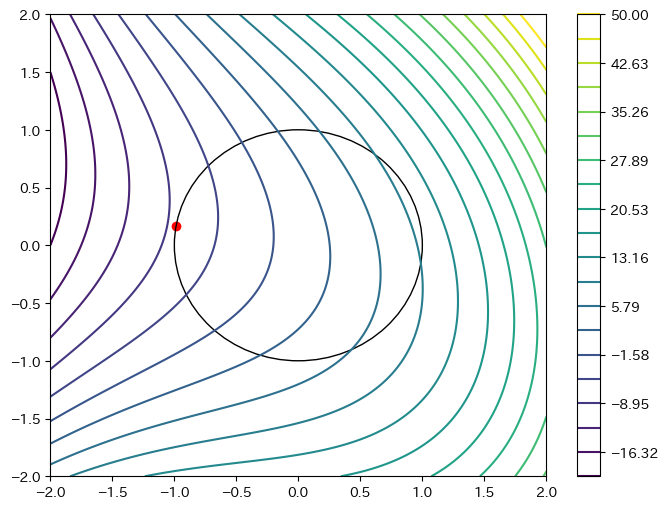

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

X_, Y_ = np.arange(-2,2.01,0.01), np.arange(-2,2.01,0.01)
X, Y = np.meshgrid(X_, Y_)
Z = X**3 + X**2 + 8*X + 4*Y**2 + 3 * X * Y

levs = np.linspace(-20,50,20)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_opt[0], x_opt[1], c="red")
cs = ax.contour(X,Y,Z,levels=levs)
ax.add_patch(plt.Circle( xy=(0, 0), radius=1, fill=False))
fig.colorbar(cs)

plt.savefig("images/chap3_NLP_2D.png")
plt.show()

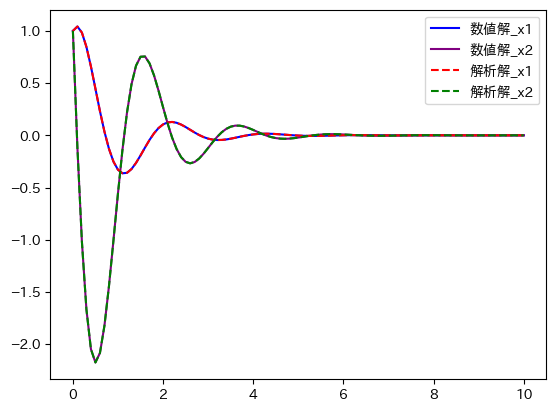

In [20]:
dt = 0.1 
t_eval = np.arange(0, 10+dt, dt)
X = [casadi.DM([1,1])]

A = casadi.DM([
    [0,1],
    [-10,-2]
])
x = casadi.SX.sym('x',2)

ode = A@x
dae = {"x":x, "ode":ode}

F = casadi.integrator('F','idas',dae,0,dt)

for t in t_eval[:-1]:
    res = F(x0=X[-1])
    X.append(res["xf"])

X = np.array(X).reshape(-1,2)

X_true_1 = casadi.exp(-t_eval)*casadi.cos(3*t_eval)+2/3*casadi.exp(-t_eval)*casadi.sin(3*t_eval)
X_true_2 = casadi.exp(-t_eval)*casadi.cos(3*t_eval)-11/3*casadi.exp(-t_eval)*casadi.sin(3*t_eval)

plt.plot(t_eval, X[:,0], label="数値解_x1", color="blue")
plt.plot(t_eval, X[:,1], label="数値解_x2", color="purple")
plt.plot(t_eval, X_true_1, label="解析解_x1", color="red",linestyle="--")
plt.plot(t_eval, X_true_2, label="解析解_x2", color="green",linestyle="--")
plt.legend()
plt.savefig("chap3_integ.png")
plt.show()    

In [21]:
# x = casadi.SX.sym('x')
# dt = 0.1 
# times = np.arange(0, 2+dt, dt)
# X_t = [1] # 初期値


# options = {'t0':0, 'tf':dt} # 積分範囲（時刻）
# ode = {'x': x, 'ode': -2*x} # 常微分方程式

# F = casadi.integrator('F', 'idas', ode, options)

# for t in times[:-1]:
#     res = F(x0=X_t[-1])
#     X_t += res['xf'].toarray().tolist()[0]

# Y_t = np.exp(-2*times)  #真の解     

# plt.plot(times, X_t, label="数値解", color="blue")
# plt.plot(times, Y_t, label="解析解", color="red")
# plt.legend()
# plt.savefig("images/chap3_integ.png")
# plt.show()    